# Time series photometry for Paper figure

## Global fit to all three K2 campaign lightcurves

Gully and Gosnell October 2020

See [GitHub Issue #13](https://github.com/BrownDwarf/subsub/issues/13)

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# subsub K2

These were manually extracted by gully using `lightkurve`.  There are now also public M67 K2SFF lightcurves on MAST: https://archive.stsci.edu/hlsp/k2sff  Might be worth revisiting, but I doubt it will make much difference!

In [2]:
! ls ../../data/K2/

FFI_calibration			 S1063_K2_C16_lightkurve_SFF.csv
S1063_K2_C05_lightkurve_SFF.csv  S1063_K2_C18_lightkurve_SFF.csv


In [3]:
dfC05 = pd.read_csv('../../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC16 = pd.read_csv('../../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

### Read in the ASASSN data.

In [4]:
#! mv /home/gully/Downloads/light_curve_ee7b673c-47c1-49dc-840b-11b347767ee9.csv ../../data/raw/ASASSN/S1063_ASASSN_20201016.csv

In [14]:
usecols = ['HJD', 'flux(mJy)', 'flux_err', 'Filter']
df_ASASSN = pd.read_csv('../../data/raw/ASASSN/S1063_ASASSN_20201016.csv', usecols=usecols)

Spot-check $g$-band, just for fun.

In [6]:
df_ASASSN

,HJD,flux(mJy),flux_err,Filter
0,2.455970e+06,99.990,99.990,V
1,2.455975e+06,19.238,0.493,V
2,2.455975e+06,19.336,0.451,V
3,2.455985e+06,99.990,99.990,V
4,2.455985e+06,17.200,0.266,V
...,...,...,...,...
2486,2.459137e+06,11.584,0.260,g
2487,2.459137e+06,12.109,0.259,g
2488,2.459139e+06,12.326,0.203,g
2489,2.459139e+06,12.768,0.184,g


In [7]:
mask = (df_ASASSN.Filter == 'g') & (df_ASASSN['flux(mJy)']!=99.990)

dfg = df_ASASSN[mask].reset_index(drop=True)

scalar = np.nanpercentile(dfg['flux(mJy)'], 85)
dfg['flux'] = dfg['flux(mJy)']/scalar
dfg['flux_err'] = dfg['flux_err']/scalar
dfg['time'] = dfg['HJD'] - 2454833.0

In [15]:
# Tidy up the dataframe
df_ASASSN = df_ASASSN[df_ASASSN.flux_err!=99.990].reset_index(drop=True)
df_ASASSN.rename(columns={'flux(mJy)':'flux', 'HJD':'time'},inplace=True)
df_ASASSN['time'] = df_ASASSN['time'] - 2454833.0

# Focus on one filter at a time...
filt = 'V'
df_ASASSN = df_ASASSN[df_ASASSN.Filter == filt].reset_index(drop=True)[['time', 'flux', 'flux_err']]
const = np.percentile(df_ASASSN.flux, 80)

# Normalize
df_ASASSN['flux'] /=const
df_ASASSN['flux_err'] /=const

# drop outliers
#good_mask = (df_ASASSN.flux > 0.7) & (df_ASASSN.time < 350)
#df_ASASSN = df_ASASSN[good_mask].reset_index(drop=True)

In [16]:
df_ASASSN

,time,flux,flux_err
0,1141.98792,1.057847,0.027109
1,1141.98965,1.063235,0.024799
2,1151.93545,0.945782,0.014627
3,1151.93731,0.944958,0.013307
4,1155.92191,0.868195,0.017321
...,...,...,...
791,3605.03557,0.884692,0.019905
792,3605.03686,0.897779,0.029913
793,3612.99541,0.949082,0.034257
794,3612.99669,1.066260,0.034532


### THE ZEROPOINTS ARE SET HERE

We tweak the campaign 5 vertical registration *within the error-bar*, which is 4.2%.  

In [17]:
campaign_5_visual_tweak = 1.04

In [18]:
# Here we retroactively assign the campaign zeropoints, which are not known a-priori.
#: Heuristic Approach:
##C05_const, C16_const, C18_const = 76956.4/1.015, 73136.2, 77089.98/1.01 # iteratively computed at bottom.

## Updated 2020: Set by K2 FFI zeropoints.
tweak =0.95 ## Visually set to match C16 to locus of ASASSN data.

C05_const, C16_const, C18_const = 76956.4/1.0*tweak*campaign_5_visual_tweak, 73136.2/0.939*tweak, 77089.98/0.982*tweak

dfC05['flux'] = dfC05['flux'] / C05_const
dfC16['flux'] = dfC16['flux'] / C16_const
dfC18['flux'] = dfC18['flux'] / C18_const

df = pd.concat([dfC05, dfC16, dfC18], ignore_index=True)

# df['flux'] = df.flux / np.percentile(df.flux, 98) Turn off if you normalize campaigns separately!
df['flux_err'] = df.flux *0.005

In [19]:
df_subset = df.sort_values('time').reset_index(drop=True)

In [20]:
t = df_subset.time.values
y = df_subset.flux
yerr = df_subset.flux_err

In [22]:
2.0 * np.pi / 23.5, 2.0 * np.pi / 13

(0.26736958753955686, 0.483321946706122)

In [23]:
import celerite
from celerite import terms

# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [24]:
%%time
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 41021.4135590629
CPU times: user 2.84 ms, sys: 214 µs, total: 3.05 ms
Wall time: 2.5 ms


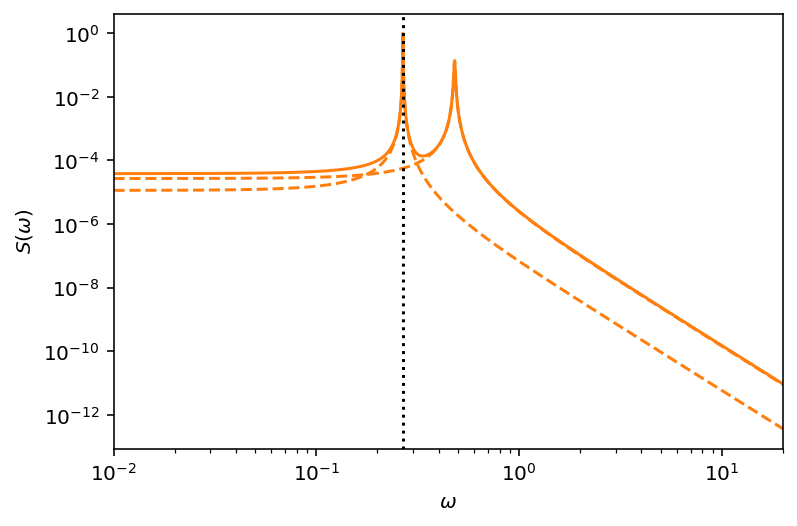

In [25]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)
color = "#ff7f0e"


plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [26]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -41187.96032052724
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0174623 , -0.36525307,  0.0174623 , -0.00727596,  0.21682354])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 360
      nit: 44
   status: 0
  success: True
        x: array([-12.97359643,  -0.62426932,  -7.09403567,   1.68170038,
        -1.392465  ])


In [27]:
np.pi*2/10**-0.8290087063581993, np.pi*2/10**-1.3457165415991024

(42.382695572041094, 139.28245400025708)

In [28]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -12.973596426808879),
             ('kernel:terms[0]:log_omega0', -0.6242693247886641),
             ('kernel:terms[1]:log_S0', -7.094035666153266),
             ('kernel:terms[1]:log_Q', 1.6817003787553402),
             ('kernel:terms[1]:log_omega0', -1.3924650002388939)])

In [29]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

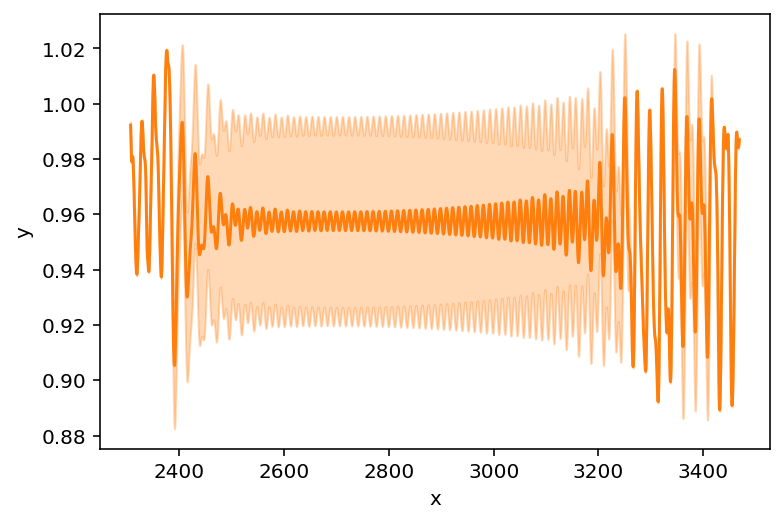

In [30]:
color = "#ff7f0e"
#plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

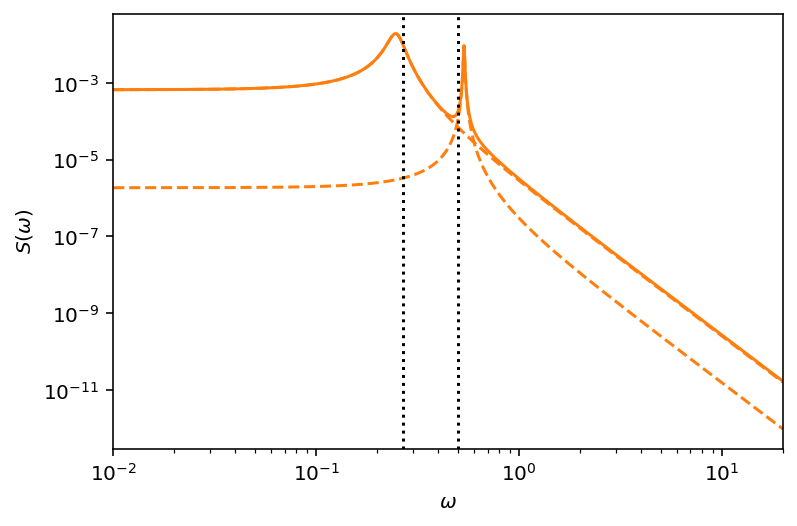

In [31]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')
plt.axvline(2.0*np.pi/12.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

## Now let's apply to the ASASSN data!

In [32]:
df_ASASSN = df_ASASSN.sort_values('time').reset_index(drop=True)

In [33]:
t = df_ASASSN.time.values
y = df_ASASSN.flux
yerr = df_ASASSN.flux_err

In [35]:
gp.get_parameter_vector()

array([-12.97359643,  -0.62426932,  -7.09403567,   1.68170038,
        -1.392465  ])

In [36]:
# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [37]:
%%time
gp2 = celerite.GP(kernel, mean=np.mean(y))
gp2.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y)))

Initial log likelihood: 583.1512477798958
CPU times: user 1.47 ms, sys: 81 µs, total: 1.55 ms
Wall time: 1.07 ms


Text(0, 0.5, 'y')

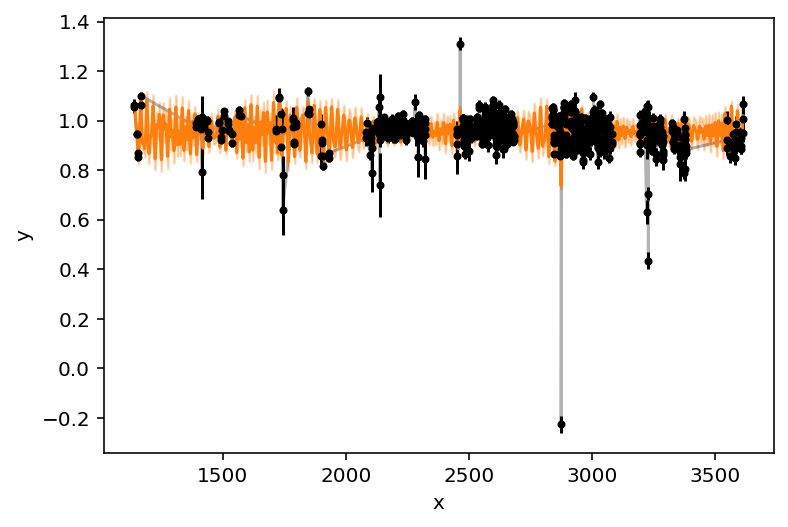

In [39]:
x = np.arange(df_ASASSN.time.iloc[0], df_ASASSN.time.iloc[-1], 1.0/2.0) # HALF DAY SAMPLING!
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

Let's transfer the GP parameters from K2:

In [40]:
gp2.set_parameter_vector(gp.get_parameter_vector())

CPU times: user 4.34 s, sys: 248 ms, total: 4.59 s
Wall time: 4.59 s


Text(0, 0.5, 'y')

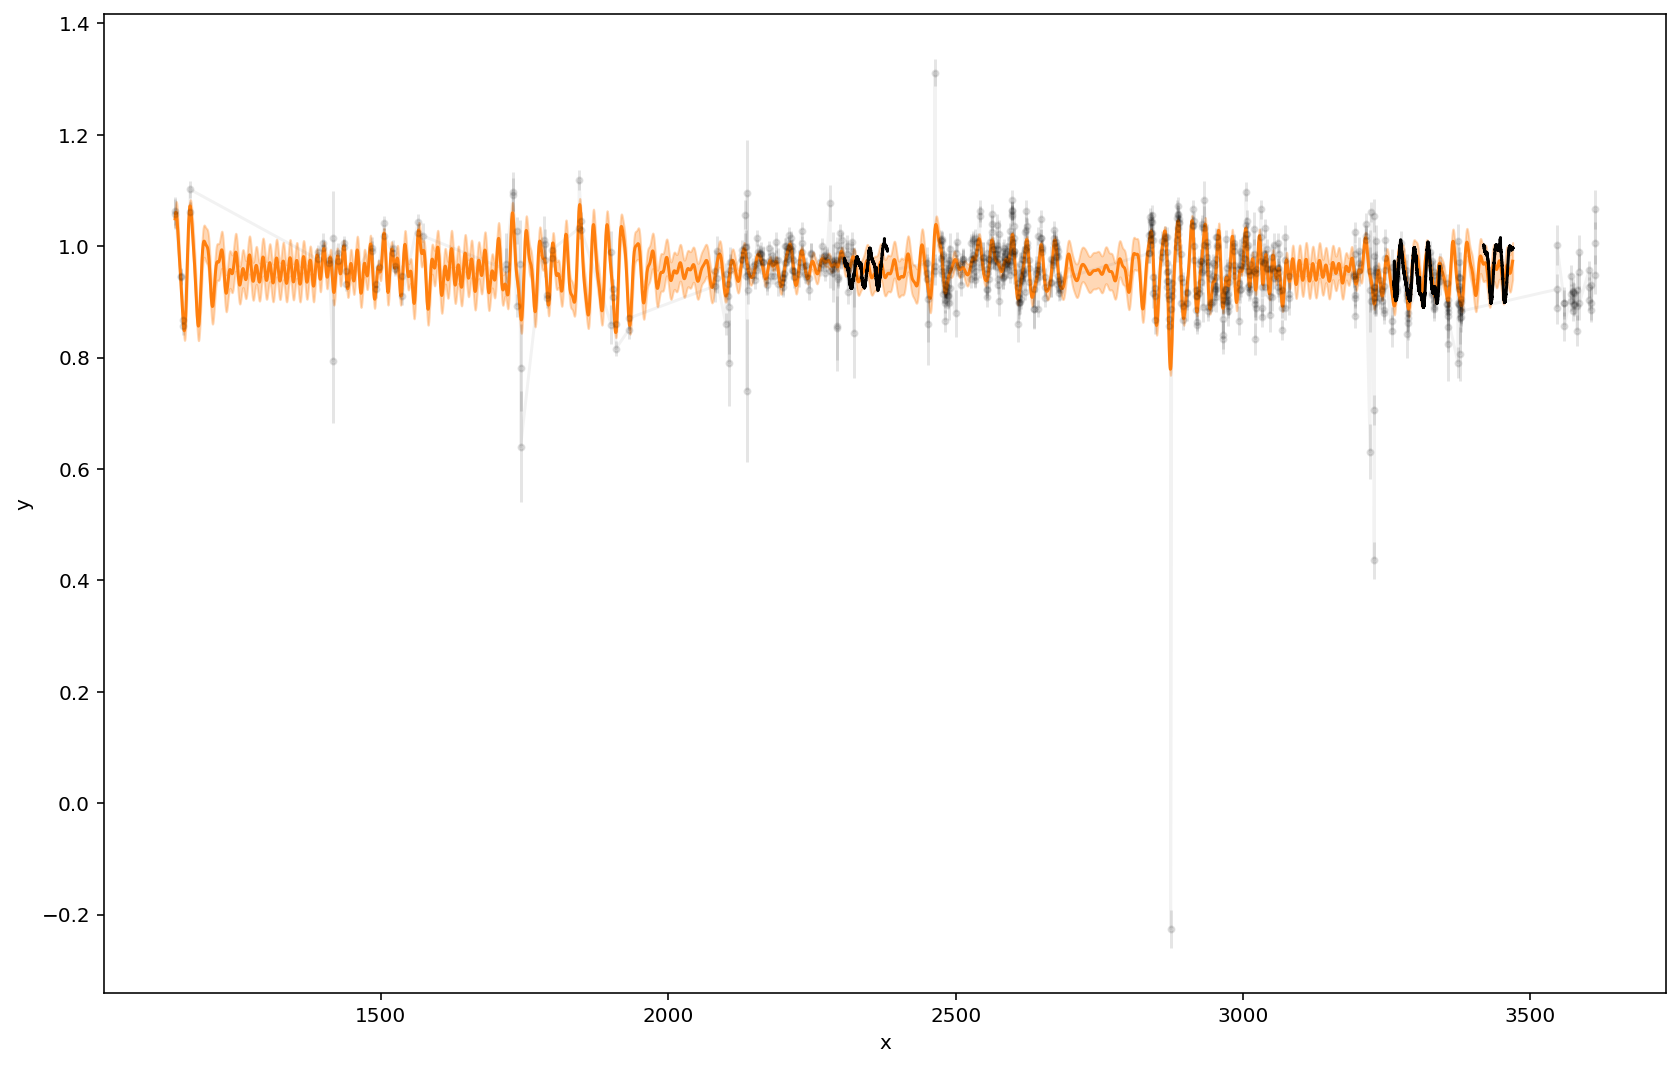

In [41]:
%%time
plt.figure(figsize=(14, 9))
x = np.arange(df_ASASSN.time.iloc[0], df.time.iloc[-1], 1.0/2.0) #half-day sampling
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_mean_K2, pred_var_K2 = gp.predict(df.flux.values, x, return_var=True)
pred_std = np.sqrt(pred_var)
pred_std_K2 = np.sqrt(pred_var_K2)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "k", lw=1.5, alpha=1)
plt.plot(dfC16.time, dfC16.flux/np.nanpercentile(dfC16.flux, 95), "k", lw=1.5, alpha=1)
plt.plot(dfC18.time, dfC18.flux/np.nanpercentile(dfC18.flux, 95), "k", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")

(2000, 2750)

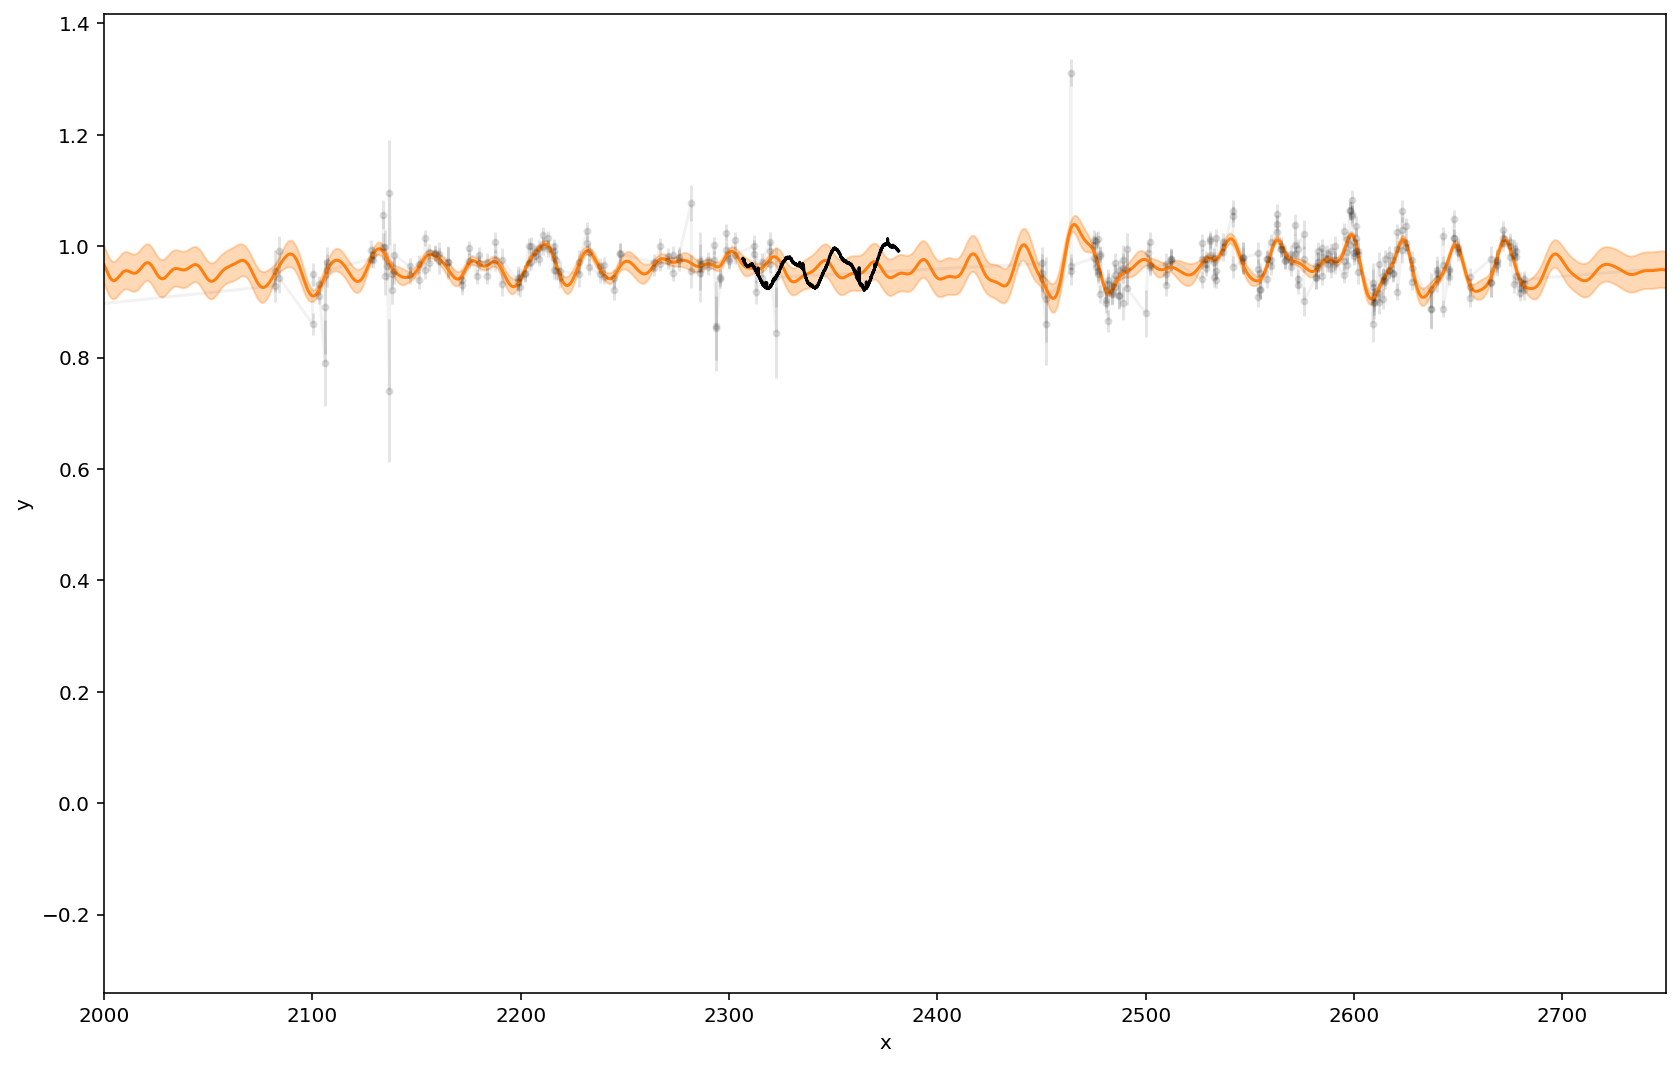

In [42]:
plt.figure(figsize=(14, 9))

plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "k", lw=1.5, alpha=1)
plt.xlabel("x")
plt.ylabel("y")

plt.xlim(2000, 2750)

(3000, 3736.548461999814)

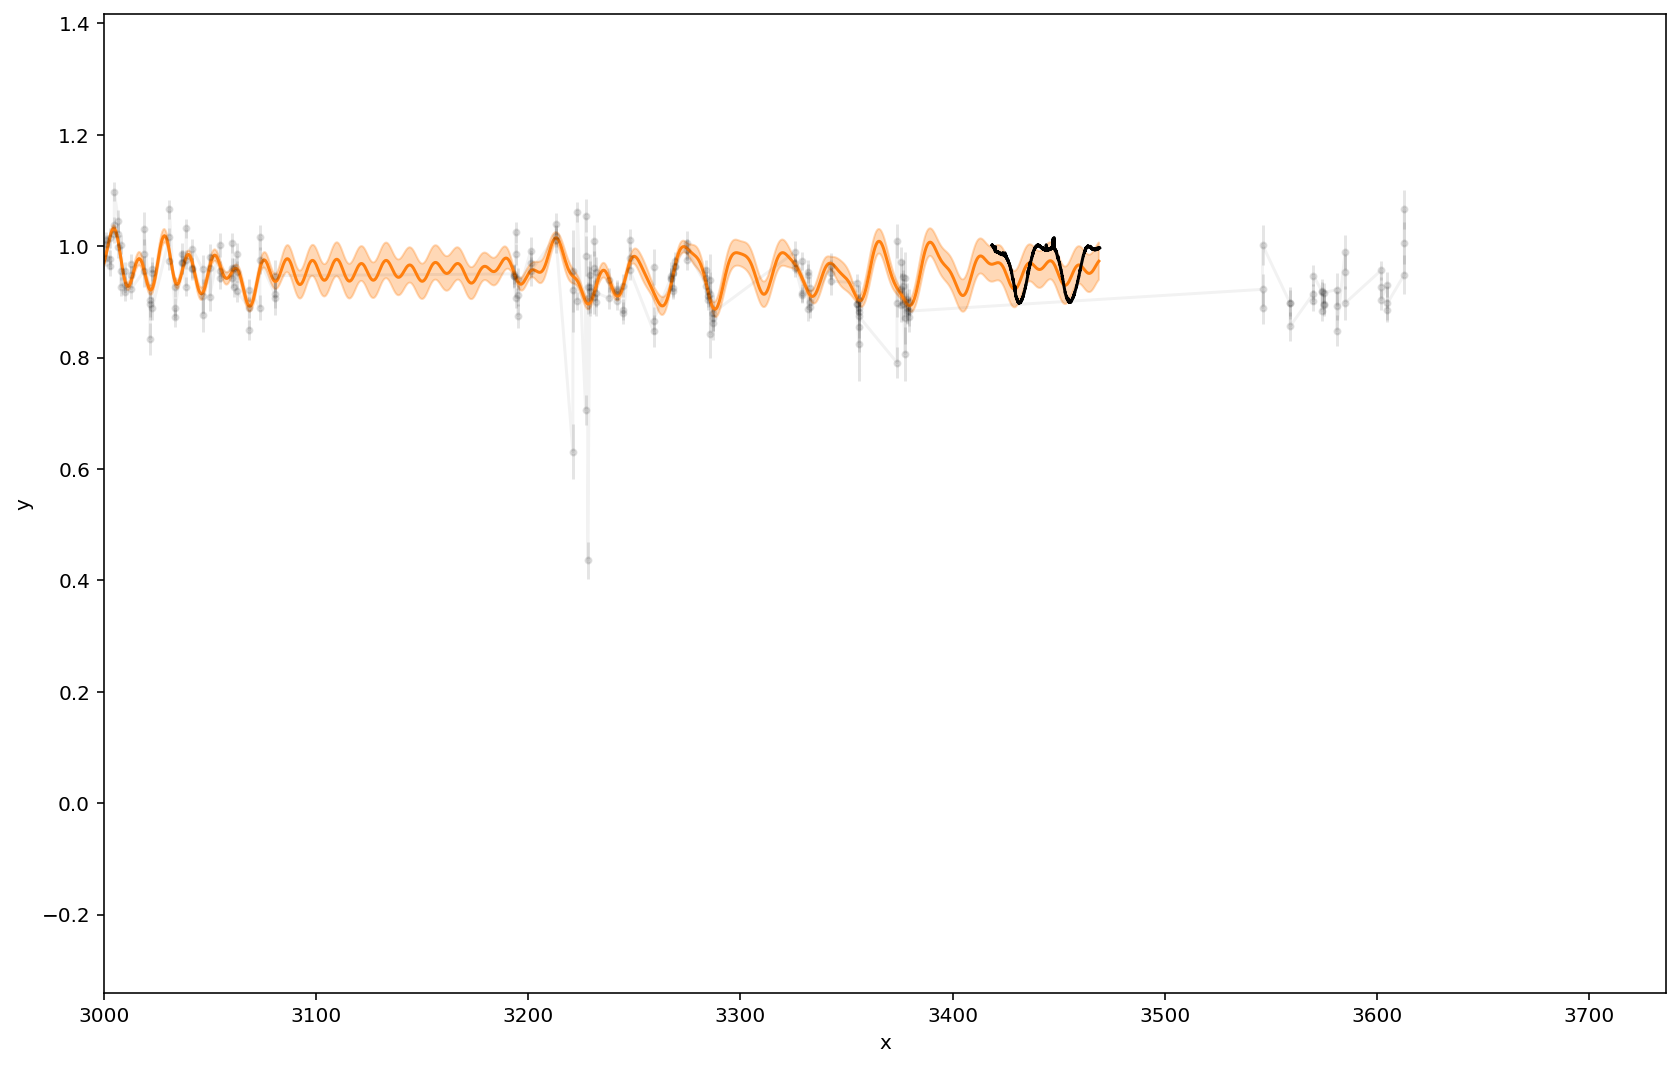

In [43]:
plt.figure(figsize=(14, 9))

plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC18.time, dfC18.flux/np.nanpercentile(dfC18.flux, 95), "k", lw=1.5, alpha=1)
plt.xlabel("x")
plt.ylabel("y")

plt.xlim(3000)

CPU times: user 29.6 ms, sys: 76 µs, total: 29.7 ms
Wall time: 27.8 ms


(3000, 3736.548461999814)

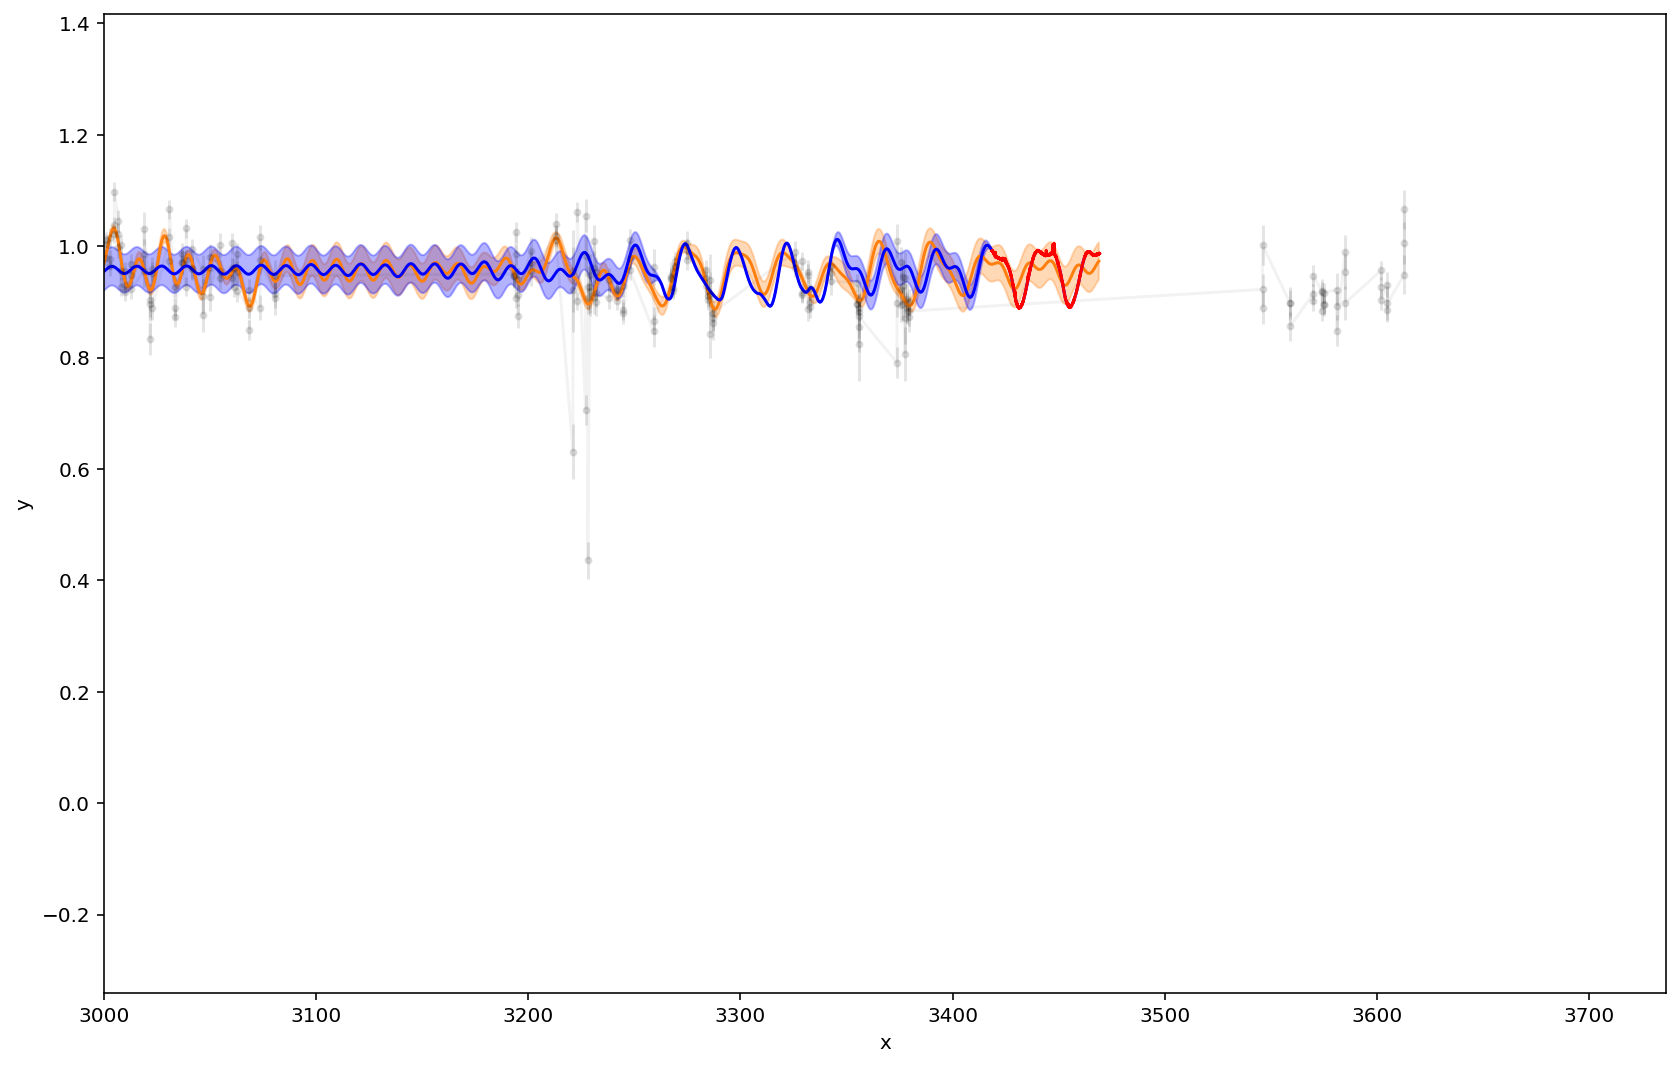

In [44]:
%%time
plt.figure(figsize=(14, 9))

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
                 edgecolor="none")

plt.plot(dfC18.time, dfC18.flux, "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(3000)

In [45]:
def compute_K2_zeropoints(df_K2_campaign):
    '''compute the K2 flux absolute value per campaign'''
    df_K2_campaign.time
    x = df_K2_campaign.time.values
    pred_mean, pred_var = gp2.predict(y, x, return_var=True)
    ratio = np.median(df_K2_campaign.flux/pred_mean)
    return ratio

In [46]:
compute_K2_zeropoints(dfC05), compute_K2_zeropoints(dfC16), compute_K2_zeropoints(dfC18)

(1.018842929483366, 0.9889116258285784, 1.0126283942286542)

## Publication quality version

In [47]:
from astropy.time import Time
times = ['2015-01-01T00:00:00.0', 
         '2016-01-01T00:00:00.0', '2017-01-01T00:00:00.0', '2018-01-01T00:00:00.0']
#times = ['2018-01-01T00:00:00.0']
nye_t = Time(times, format='isot', scale='utc')

nye_tick_locations = nye_t.jd - 2454833
#nye_t.decimalyear

In [48]:
import seaborn as sns
sns.set_context("paper")

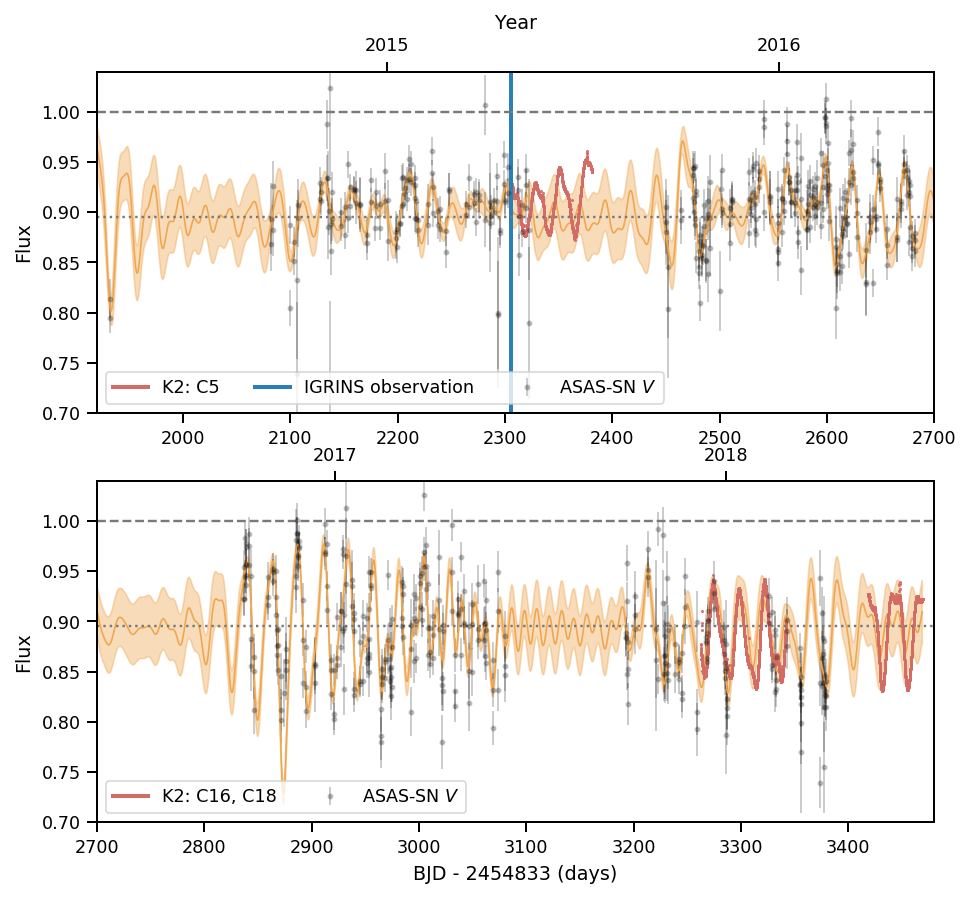

In [60]:
#%%time
fig, axes = plt.subplots(nrows=2, figsize=(7.5, 6.9), squeeze=True)
ax2 = axes[0].twiny()
ax4 = axes[1].twiny()

peak = 1.07

color = "#EFA64F"
axes[0].errorbar(t, y/peak, yerr=yerr/peak, fmt=".k", ms=4, capsize=0, alpha=0.2, lw=1, label='ASAS-SN $V$')
axes[0].plot(x, pred_mean/peak, color=color, lw=0.8)
axes[0].fill_between(x, pred_mean/peak+pred_std/peak, pred_mean/peak-pred_std/peak, color=color, alpha=0.4,
                 edgecolor="none", lw=0.8)

axes[0].plot(df.time, df.flux.values/peak, '.', color="#D36C65", alpha=1, ms=1)
axes[0].plot(df.time, 0.0*df.flux-10, '-', color="#D36C65", alpha=1, lw=2, label='K2: C5')

igrins_obs = 57138.64 - 54833
axes[0].axvline(igrins_obs, linestyle='solid', color='#2980b9', label="IGRINS observation", lw=2)

axes[0].axhline(1.0, linestyle='dashed', color='#797979')

axes[0].axhline(0.895, linestyle='dotted', color='#797979')

axes[0].set_xlabel(None)
axes[0].set_ylabel("Flux")
axes[0].set_ylim(0.7, 1.04)
axes[0].set_xlim(1920, 2700)
#ax1.set_xlim(3200, 3470)

axes[0].legend(loc='lower left', ncol=3)
#ax1.legend(bbox_to_anchor=(0.95, 0.95))

ax2.set_xlim(1920, 2700)
#ax2.set_xlim(3200, 3470)
ax2.set_xticks(nye_tick_locations[0:2])
ax2.set_xticklabels(nye_t.decimalyear.astype(np.int)[0:2])
ax2.set_xlabel("Year")



### SEcond panel

axes[1].errorbar(t, y/peak, yerr=yerr/peak, fmt=".k", ms=4, capsize=0, alpha=0.2, lw=1, label='ASAS-SN $V$')
axes[1].plot(x, pred_mean/peak, color=color, lw=0.8)
axes[1].fill_between(x, pred_mean/peak+pred_std/peak, pred_mean/peak-pred_std/peak, color=color, alpha=0.4,
                 edgecolor="none", lw=0.8)

axes[1].plot(df.time, df.flux.values/peak, '.', color="#D36C65", alpha=1, ms=1)
axes[1].plot(df.time, 0.0*df.flux-10, '-', color="#D36C65", alpha=1, lw=2, label='K2: C16, C18')

axes[1].axhline(1.0, linestyle='dashed', color='#797979')

axes[1].axhline(0.895, linestyle='dotted', color='#797979')

axes[1].set_xlabel("BJD - 2454833 (days)")
axes[1].set_ylabel("Flux")
axes[1].set_ylim(0.7, 1.04)
axes[1].set_xlim(2700, 3480)
#ax1.set_xlim(3200, 3470)

axes[1].legend(loc='lower left', ncol=3)
#ax1.legend(bbox_to_anchor=(0.95, 0.95))

ax4.set_xlim(2700, 3480)
#ax2.set_xlim(3200, 3470)
ax4.set_xticks(nye_tick_locations[2:])
ax4.set_xticklabels(nye_t.decimalyear.astype(np.int)[2:])
ax4.set_xlabel(None)


plt.savefig('../../document/figures/2020_K2_ASASSN_lcurve_2panel.pdf', bbox_inches='tight')

# Predict the flux at the time of the IGRINS observation

In [50]:
igrins_flux_est, igrins_flux_unc = gp2.predict(y, np.array([igrins_obs]), return_var=True)

In [51]:
igrins_flux_est/peak, igrins_flux_unc/peak

(array([0.91242245]), array([0.00020421]))

In [56]:
import lightkurve as lk

ModuleNotFoundError: No module named 'lightkurve'

In [55]:
dir(lk)

NameError: name 'lk' is not defined

In [52]:
tpf=lk.search_targetpixelfile()

In [39]:
! xdg-open ../../document/figures/

In [40]:
 STOP!!!

SyntaxError: invalid syntax (<ipython-input-40-269510821509>, line 1)

In [ ]:
import seaborn as sns
sns.set_context("poster")


#%%time
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()

peak = 1.07

igrins_obs = 57138.64 - 54833

color = "#EFA64F"
ax1.errorbar(t, y/peak, yerr=yerr/peak, fmt=".k", ms=7, capsize=0, alpha=0.2, lw=1, label='ASASSN $V$')
ax1.plot(x, pred_mean/peak, color=color, lw=2)
ax1.fill_between(x, pred_mean/peak+pred_std/peak, pred_mean/peak-pred_std/peak, color=color, alpha=0.3,
                 edgecolor="none", lw=1, label="Celerite fit")

ax1.plot(df.time, df.flux.values/peak, '.', color="#D36C65", alpha=1, ms=5)
ax1.plot(df.time, 0.0*df.flux-10, '-', color="#D36C65", alpha=1, lw=4, label='K2 C5')

ax1.axhline(1.0, linestyle='dashed', color='#797979')
ax1.axvline(igrins_obs, linestyle='dotted', color='k', label="IGRINS observation")

#ax1.axhline(0.93, linestyle='dashed', color='#783891')

ax1.set_xlabel("BJD - 2454833 (days)")
ax1.set_ylabel("flux")
ax1.set_ylim(0.7, 1.04)
#ax1.set_xlim(1717, 3470)
ax1.set_xlim(2100, 2400)
#ax1.set_xlim(3200, 3470)

ax1.legend(loc='lower left')

#ax2.set_xlim(2200, 2400)
#ax2.set_xlim(1717, 3470)
#ax2.set_xlim(3200, 3470)
#ax2.set_xticks(nye_tick_locations)
#ax2.set_xticklabels(nye_t.decimalyear.astype(np.int))
#ax2.set_xlabel("Year")


#plt.savefig('../document/figures/c5_lightcurve_V_review.pdf', bbox_inches='tight', dpi=300, transparent=True)

In [ ]:
df_ASASSN.time.iloc[0], df.time.iloc[-1]

In [ ]:
sns.set_context("talk")
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
ax1.plot(df.time, df.flux.values/peak, '.', color="#D36C65", alpha=1, ms=7)
ax1.plot(df.time, 0.0*df.flux-10, '-', color="#D36C65", alpha=1, lw=4, label='K2 C5')
ax1.axvline(igrins_obs, linestyle='dotted', color='k', label="IGRINS observation")
ax1.axhline(1.0, linestyle='dashed', color='#797979', label="Maximum light (2014-2018)")
ax1.set_xlabel("BJD - 2454833 (days)")
ax1.set_ylabel("flux")
ax1.set_ylim(0.75, 1.04)
ax1.set_xlim(2300, 2390)
ax1.legend()
#plt.savefig('../document/figures/c5_lightcurve_V_review_noGP.pdf', bbox_inches='tight', dpi=300, transparent=True)

The end!